# Step #1 Get a List of Crypto Projects

In [95]:
# Work in progress!
# A tutorial for this file will soon be available at www.relataly.com

# Tested with Python 3.9.13, Matplotlib 3.5.2, Seaborn 0.11.2, numpy 1.21.5, plotly 4.1.1, cryptocompare 0.7.6

import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates # Formatting dates
import matplotlib.ticker as ticker
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})
import cryptocompare as cc
import requests
import IPython
import yaml
import json
from PIL import Image

# Set the API Key 
yaml_file = open('API Keys/api_config_cryptocompare.yml', 'r')  
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key']
cc.cryptocompare._set_api_key_parameter(api_key)

# Request a list of coins available on cry# ptocompare
coinlist_dict = cc.get_coin_list()
crypto_list_df = pd.DataFrame.from_dict(coinlist_dict, orient='index', dtype=None, columns=None)
crypto_list_df['creation_date'] = pd.to_datetime(crypto_list_df['ContentCreatedOn'], unit='s').dt.date
crypto_list_df['creation_date_yearmonth'] = pd.to_datetime(crypto_list_df['creation_date']).dt.strftime('%Y-%m')
crypto_list_df.drop(columns=['ContentCreatedOn', 'SortOrder', 'Name', 'FullName', 'Url', 'Id', 'Sponsored', 'AssetTokenStatus'], inplace=True)
crypto_list_df.head()

,ImageUrl,Symbol,CoinName,Description,Algorithm,ProofType,Taxonomy,Rating,creation_date,creation_date_yearmonth
BTCD,/media/19630/btcd_1.png,BTCD,BitcoinDark,Bitcoin Dark (BTCD) is a PoW and PoS hybrid al...,SHA-256,PoW/PoS,"{'Access': 'Permissionless', 'FCA': 'Exchange'...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-03-30,2015-03
CRAIG,/media/20022/craig.png,CRAIG,CraigsCoin,CraigCoin (CRAIG) is a 100% pure PoS or Proof ...,X11,PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-03-30,2015-03
XBS,/media/351060/xbs_1.png,XBS,Bitstake,To create the infrastructure necessary to impl...,X11,PoW/PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-04-10,2015-04
XPY,/media/20076/xpy_1.png,XPY,PayCoin,Paycoin is an SHA256 cryptocurrency that switc...,SHA-256,PoS,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-04-10,2015-04
PRC,/media/20393/prc.png,PRC,ProsperCoin,ProsperCoin is a PoW cryptocurrency with a mod...,Scrypt,PoW,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...","{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",2015-02-25,2015-02


In [57]:
# Display coins with Weiss Rating
json_struct = json.loads(crypto_list_df[['Rating','Symbol']].to_json(orient="records"))    
df_flat = pd.json_normalize(json_struct)
coins_sorted = df_flat[df_flat['Rating.Weiss.Rating'] != ""].sort_values(by=['Rating.Weiss.Rating', 'Rating.Weiss.TechnologyAdoptionRating', 'Rating.Weiss.MarketPerformanceRating'])
coins_sorted.reset_index().drop(columns=['index'], inplace=True)
coins_sorted.index = np.arange(1, len(coins_sorted) + 1)
coins_sorted.head(15)

,Symbol,Rating.Weiss.Rating,Rating.Weiss.TechnologyAdoptionRating,Rating.Weiss.MarketPerformanceRating
1,MATIC,B,B+,C+
2,LINK,B,B+,D+
3,BTC,B+,A-,D
4,SAND,B-,B,C
5,MANA,B-,B,C-
6,MKR,B-,B,C-
7,SUSHI,B-,B,C-
8,XLM,B-,B,D
9,ETH,B-,B,D
10,LTC,B-,B,D


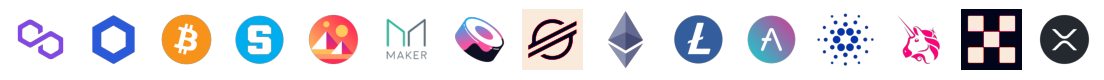

In [58]:
# Print crypto symbol icons
cryptonames = list(coins_sorted['Symbol'].head(15))
cryptonames
fig = plt.figure(figsize=(14, 14))
for i, cryptoname in enumerate(cryptonames):
    coinname_url = 'http://www.cryptocompare.com' + crypto_list_df['ImageUrl'][crypto_list_df['Symbol'] == cryptoname][0]
    im = Image.open(requests.get(coinname_url, stream=True).raw)
    fig.add_subplot(1, len(cryptonames), i+1)
    plt.imshow(im)
    plt.axis('off')

# Step #2 Load Historical Price Data

In [59]:
# Load historic BTC prices
def load_crypto_price(symbol):
    historic_dict = cc.get_historical_price_day_from(symbol)
    df = pd.DataFrame(historic_dict)
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df['date_yearmonth'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
    df.drop(columns=['time', 'conversionType', 'conversionSymbol'])
    df.head()
    return df

historic_btc_price_df = load_crypto_price('BTC')
historic_eth_price_df = load_crypto_price('ETH')
historic_btc_price_df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,date,date_yearmonth
0,1314403200,6.145,6.008,6.008,1.6380,9.873,6.145,direct,,2011-08-27,2011-08
1,1314489600,6.398,6.201,6.145,0.4928,3.098,6.398,direct,,2011-08-28,2011-08
2,1314576000,6.398,6.398,6.398,0.0000,0.000,6.398,direct,,2011-08-29,2011-08
3,1314662400,6.398,6.398,6.398,0.0000,0.000,6.398,direct,,2011-08-30,2011-08
4,1314748800,6.398,6.398,6.398,0.0000,0.000,6.398,direct,,2011-08-31,2011-08


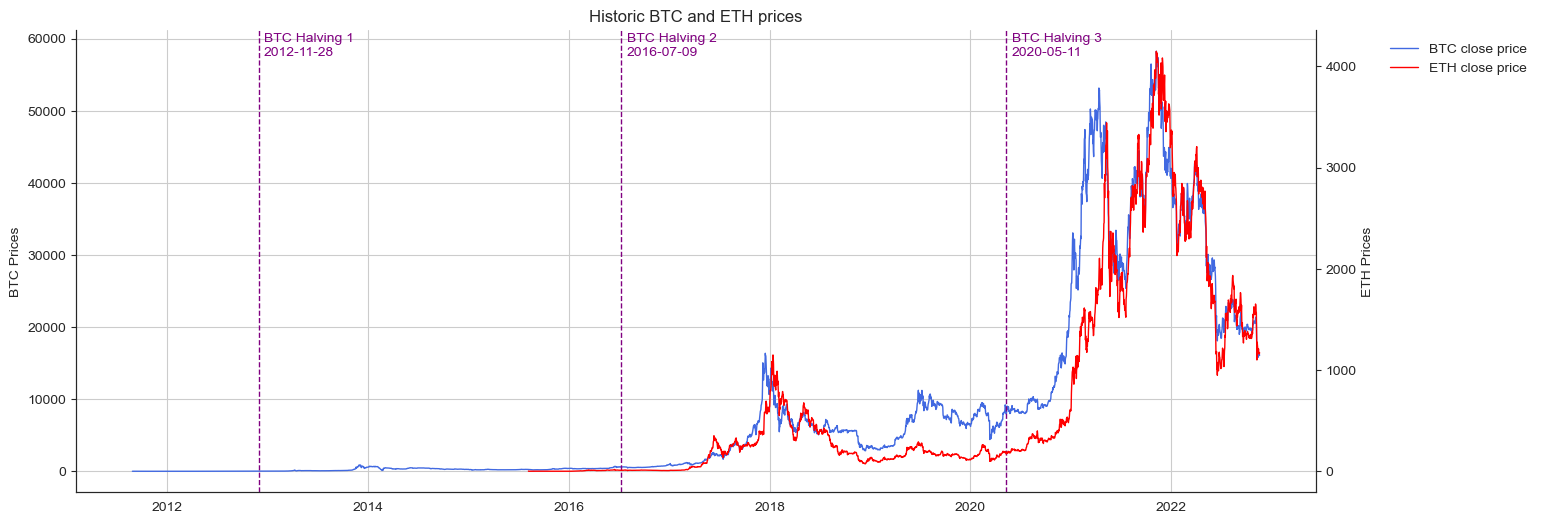

In [97]:
# Creating a Lineplot: Historic BTC and ETH prices

# this function adds bitcoin halving dates as vertical lines
def add_halving_dates(ax, df_x_dates, df_ax1_y):
    halving_dates = ['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', '2024-03-12', '2028-06-01'] 
    dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in halving_dates]

    for i, datex in enumerate(dates_list):
        halving_ts = pd.Timestamp(datex)
        x_max = df_x_dates.max()  + timedelta(days=365)
        x_min = df_x_dates.min()  - timedelta(days=365)
        if (halving_ts < x_max) and (halving_ts > x_min):
            ax.axvline(x=datex, color = 'purple', linewidth=1, linestyle='dashed')
            ax.text(x=datex  + timedelta(days=20), y=df_ax1_y.max()*0.99, s='BTC Halving ' + str(i) + '\n' + str(datex), color = 'purple')

# this function creates a nice legend for twinx plots
def add_twinx_legend(ax1, ax2, x_anchor=1.18, y_anchor=1.0):
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=1, facecolor='white', framealpha=0, bbox_to_anchor=(x_anchor, y_anchor))
    ax2.get_legend().remove()

fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=historic_btc_price_df, x='date', y='close', color='royalblue', linewidth=1.0, label='BTC close price', ax=ax1)
ax1.set_ylabel('BTC Prices')
ax1.set(xlabel=None)
ax2 = ax1.twinx()
sns.lineplot(data=historic_eth_price_df, x='date', y='close', color='red', linewidth=1.0, label='ETH close price', ax=ax2)
ax2.set_ylabel('ETH Prices')
add_twinx_legend(ax1, ax2)
add_halving_dates(ax1, historic_btc_price_df.date, historic_btc_price_df.close)
plt.grid()
plt.title('Historic BTC and ETH prices')
plt.show()

# Step #3 Historic BTC Balance Distribution

In [61]:
# Load Historic BTC Balance Distribution Data 
def get_balance_distribution_data(crypto_symbol, data_limit):
  url = f'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={crypto_symbol}&limit={data_limit}'

  headers = {
    'authorization': 'Apikey ' + api_key,
  }

  # API call to the cryptocompare blockchain historic data endpoint
  session = requests.Session()
  session.headers.update(headers)
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_flat = pd.json_normalize(json_struct)
  df_flat['date'] = pd.to_datetime(df['time'], unit='s')
  df_flat = pd.concat([df_flat.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_flat.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['from_' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to', 'time'], inplace=True)
  df_flat
  return df_flat

data_limit = 2000
distribution_btc_df = get_balance_distribution_data('BTC', data_limit)
# slight corrections for BTC distribution
distribution_btc_df = distribution_btc_df[~distribution_btc_df['range'].isin(['from_100000.0_to_0.0'])]
distribution_btc_df['range'].iloc[distribution_btc_df['range'] == 'from_1e-08_to_0.001'] = 'from_0.0_to_0.001'
distribution_btc_df

,date,totalVolume,addressesCount,range
0,2017-05-29,1.965964e+03,10022074.0,from_0.0_to_0.001
1,2017-05-29,1.186231e+04,3121233.0,from_0.001_to_0.01
2,2017-05-29,8.576906e+04,2743569.0,from_0.01_to_0.1
3,2017-05-29,3.994446e+05,1233223.0,from_0.1_to_1.0
4,2017-05-29,1.231172e+06,449210.0,from_1.0_to_10.0
...,...,...,...,...
19994,2022-11-18,1.982321e+06,791104.0,from_1.0_to_10.0
19995,2022-11-18,4.364280e+06,136193.0,from_10.0_to_100.0
19996,2022-11-18,3.859087e+06,13705.0,from_100.0_to_1000.0
19997,2022-11-18,4.630962e+06,1980.0,from_1000.0_to_10000.0


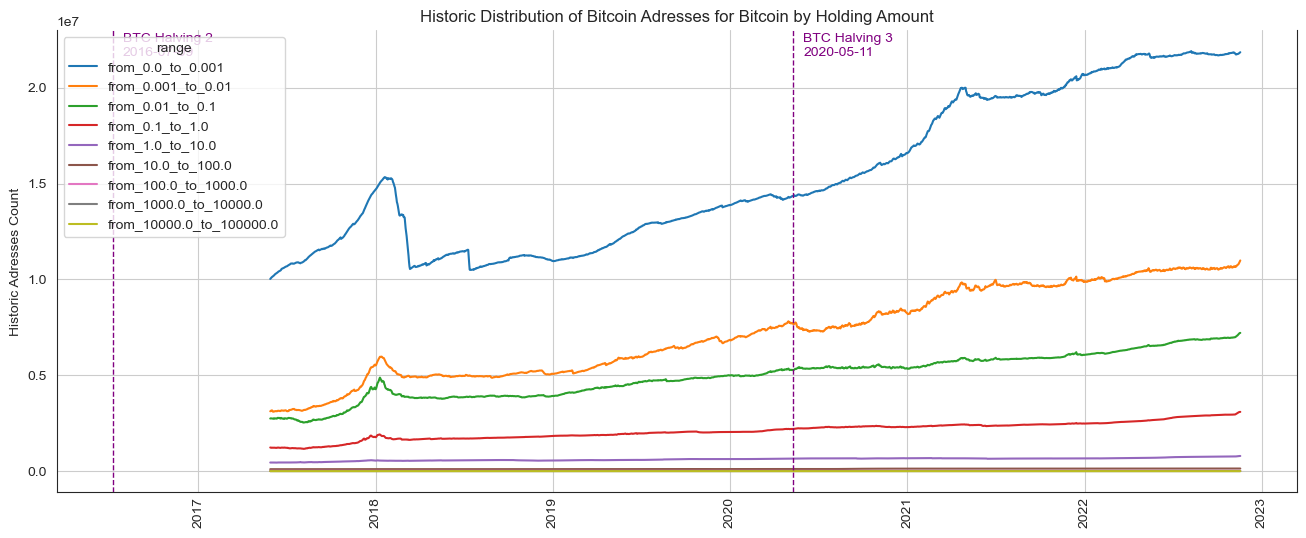

In [86]:
# Creating a Lineplot: Emergence of Crypto Projects vs Bitcoin Price
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=distribution_btc_df, x='date', y='addressesCount', hue='range', ax=ax1)
plt.ylabel('Historic Adresses Count')
plt.grid()
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.set(xlabel=None)
add_halving_dates(ax1, distribution_btc_df.date, distribution_btc_df.addressesCount)
plt.title('Historic Distribution of Bitcoin Adresses for Bitcoin by Holding Amount')
plt.show()

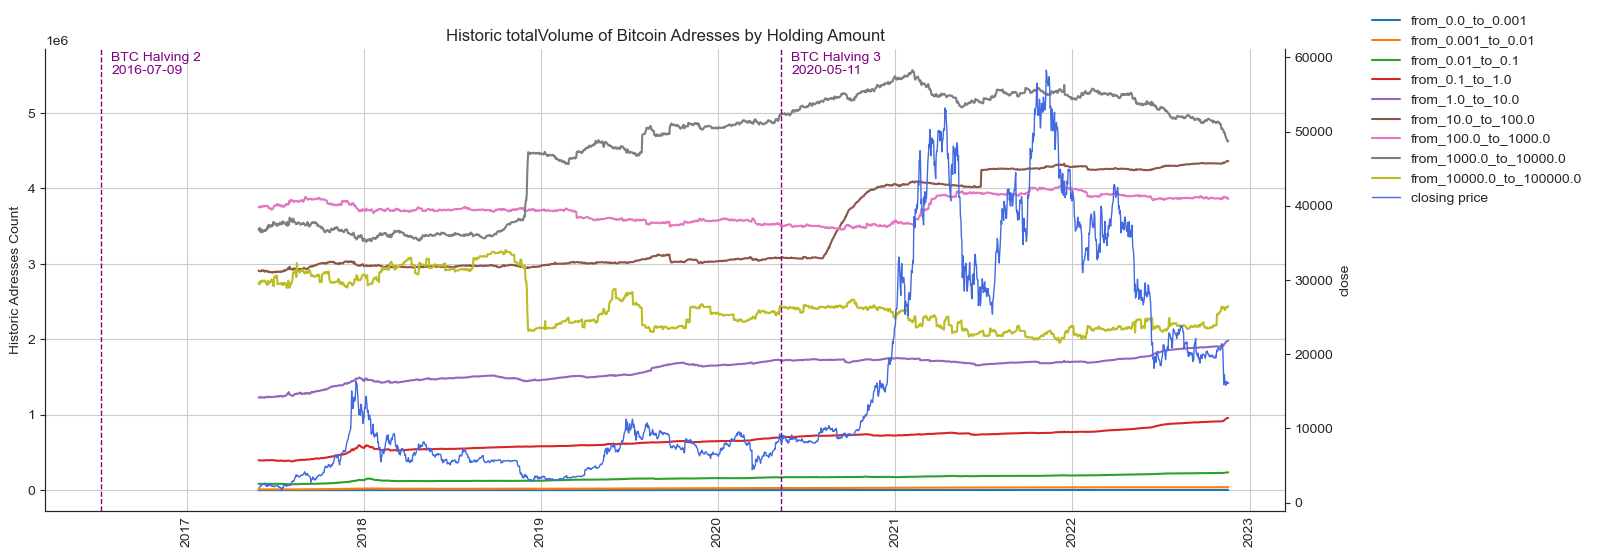

In [83]:
# Creating a Lineplot: Historic totalVolume of Bitcoin Adresses by Holding Amount
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=distribution_btc_df, x='date', y='totalVolume', hue='range', ax=ax1)
plt.ylabel('Historic Adresses Count')
plt.grid()
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax2 = ax1.twinx()
sns.lineplot(data=historic_btc_price_df[-1 * data_limit:], x='date', y='close', linewidth=1.0, color='royalblue', ax=ax2, label='closing price')
add_twinx_legend(ax1, ax2, 1.25,1.1)
ax1.set(xlabel=None)
add_halving_dates(ax1, distribution_btc_df.date, distribution_btc_df.totalVolume)
plt.title('Historic totalVolume of Bitcoin Adresses by Holding Amount')
plt.show()

# Step #4 Historic Project Emergence

In [64]:
# Merge prices data with Bitcoin onchain data
historic_project_count_df = crypto_list_df[['Symbol','creation_date_yearmonth']].groupby(by=['creation_date_yearmonth']).count()
historic_btc_price_monthly_average_df = historic_btc_price_df[['close','date_yearmonth']].groupby(by=['date_yearmonth']).mean()
merge_df = historic_project_count_df.join(historic_btc_price_monthly_average_df)
merge_df.index.names = ['date']
merge_df.rename(columns={'Symbol':'Count'}, inplace=True)

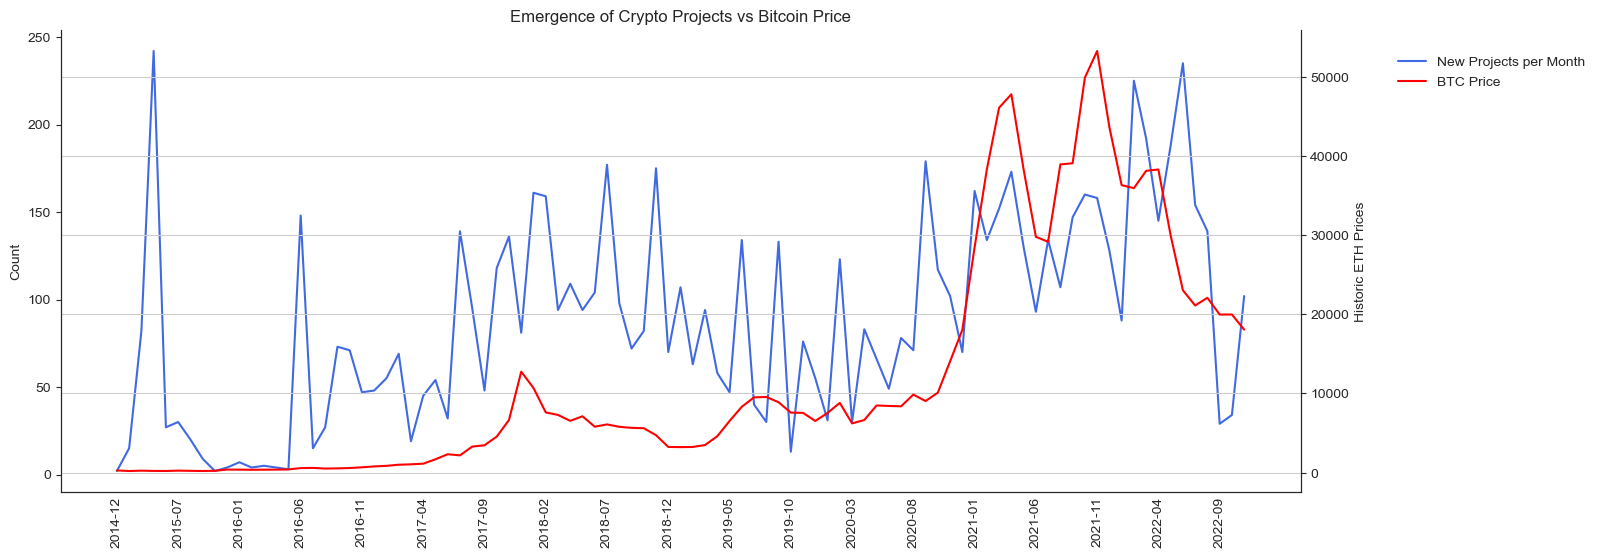

In [88]:
# Creating a Lineplot: Emergence of Crypto Projects vs Bitcoin Price
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=merge_df, x='date', y='Count', color='royalblue', label='New Projects per Month', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=merge_df, x='date', y='close', color='red', label='BTC Price',ax=ax2)
plt.ylabel('Historic ETH Prices')
plt.grid()
ax1.set(xlabel=None)
add_twinx_legend(ax1, ax2, 1.24, 0.97)
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Emergence of Crypto Projects vs Bitcoin Price')
plt.show()

# Step #5 Load OnChain Data

In [66]:
# Load Historic OnChain Data for Bitcoin

def get_onchain_data(crypto_symbol, data_limit):
  url = f'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym={crypto_symbol}&limit={data_limit}'

  headers = {
    'authorization': 'Apikey ' + api_key,
  }

  # API call to the cryptocompare blockchain historic data endpoint
  session = requests.Session()
  session.headers.update(headers)
  response = session.get(url)

  # Conversion of the response to dataframe
  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.drop(columns='time', inplace=True)
  return df

data_limit = 2000
onchain_btc_df = get_onchain_data('BTC', data_limit)
onchain_eth_df = get_onchain_data('ETH', data_limit)
onchain_btc_df.head()

# filter some faulty values
onchain_btc_df = onchain_btc_df[onchain_btc_df['hashrate'] > 0.0]

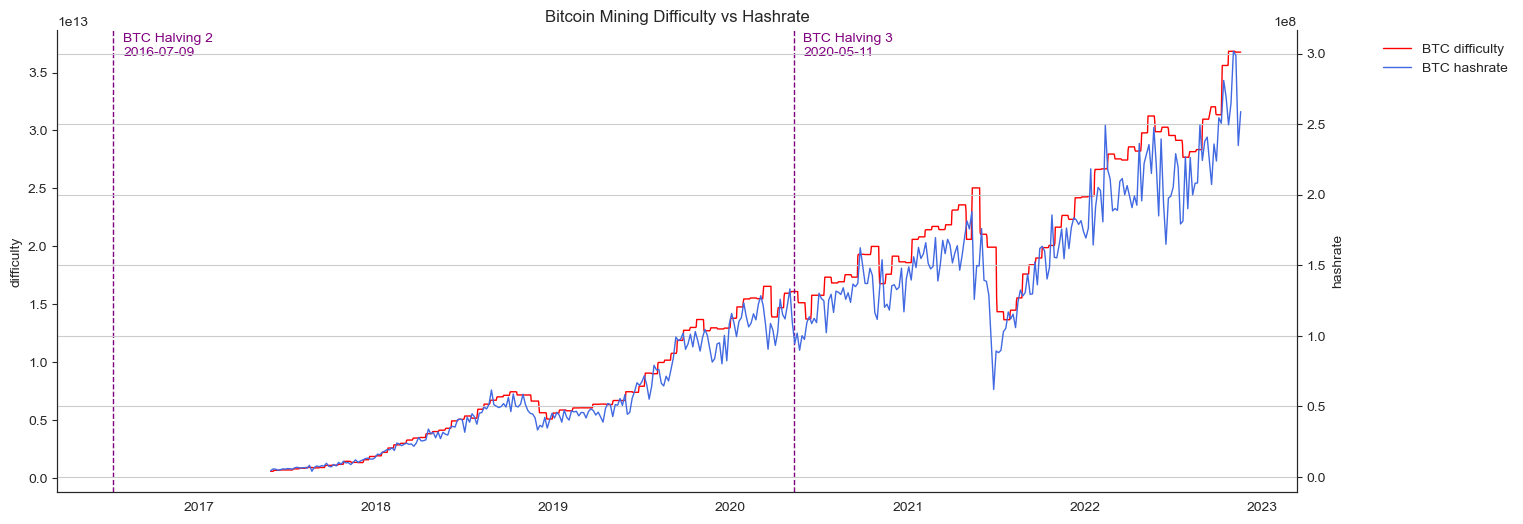

In [79]:
# Creating a Lineplot: Bitcoin  Difficulty vs Hashrate

fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_btc_df, x='date', y='difficulty', linewidth=1.0, color='red', ax=ax1, label='BTC difficulty')
ax2 = ax1.twinx()
sns.lineplot(data=onchain_btc_df[::5], x='date', y='hashrate', linewidth=1.0, color='royalblue', ax=ax2, label='BTC hashrate')
add_twinx_legend(ax1, ax2)
add_halving_dates(ax1, onchain_btc_df.date, onchain_btc_df.difficulty)
plt.grid()
ax1.set(xlabel=None)
plt.title('Bitcoin Mining Difficulty vs Hashrate')
plt.show()

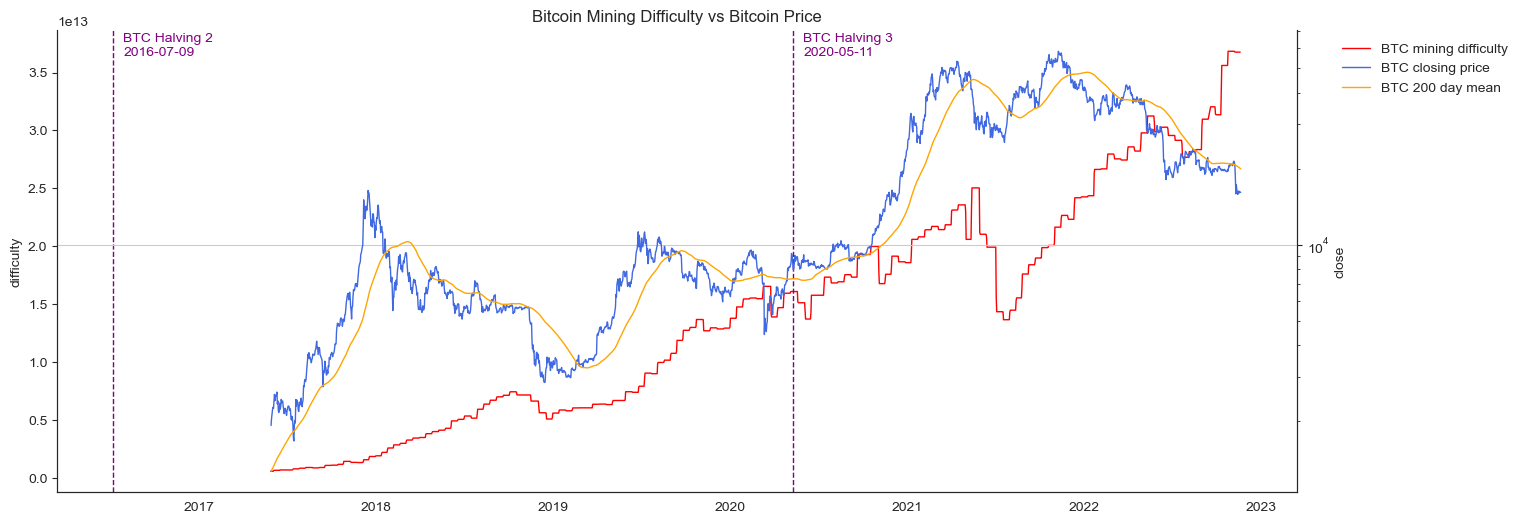

In [81]:
# close_average
historic_btc_price_df['close_avg'] = historic_btc_price_df['close'].rolling(window=100).mean() 

# Creating a Lineplot: Bitcoin Mining Difficulty vs Bitcoin Price
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=onchain_btc_df, x='date', y='difficulty', linewidth=1.0, color='red', ax=ax1, label='BTC mining difficulty')
ax2 = ax1.twinx()
sns.lineplot(data=historic_btc_price_df[-1 * data_limit:], x='date', y='close', linewidth=1.0, color='royalblue', ax=ax2, label='BTC closing price')
sns.lineplot(data=historic_btc_price_df[-1 * data_limit:], x='date', y='close_avg', linewidth=1.0, color='orange', ax=ax2, label='BTC 200 day mean')
add_twinx_legend(ax1, ax2)
add_halving_dates(ax1, onchain_btc_df.date, onchain_btc_df.difficulty)
ax2.set_yscale('log')
ax1.set(xlabel=None)
plt.grid()
plt.title('Bitcoin Mining Difficulty vs Bitcoin Price')
plt.show()

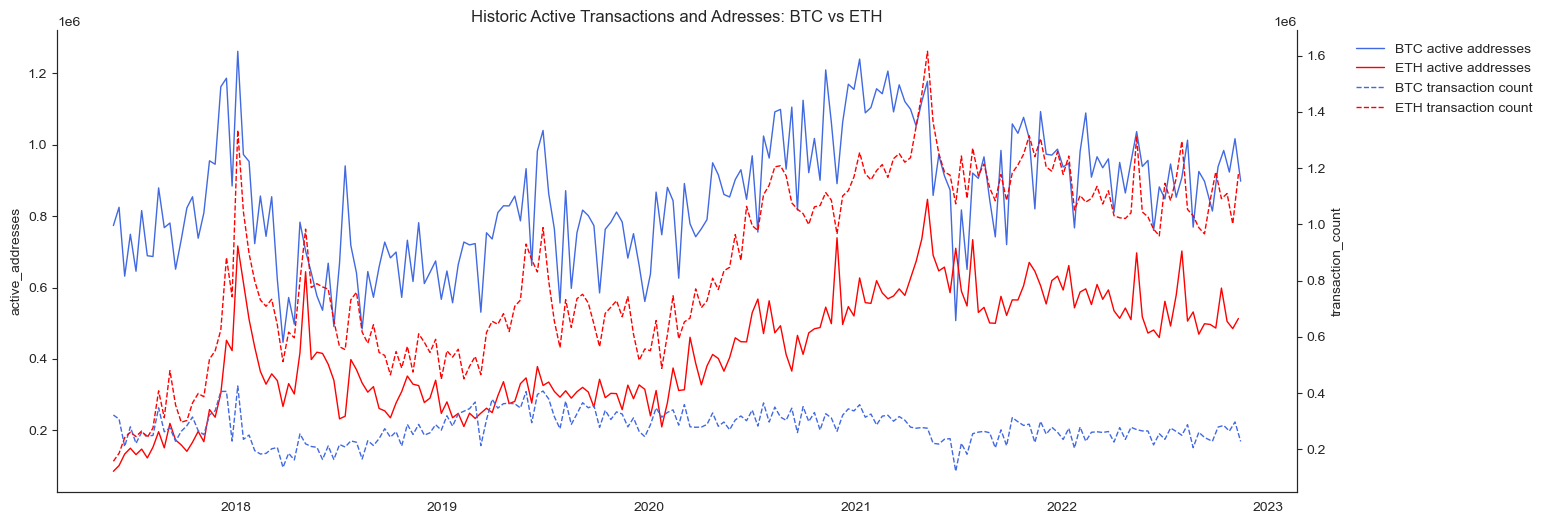

In [82]:
# Creating a Lineplot: Historic Active Transactions and Adresses: BTC vs ETH
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()
sns.lineplot(data=onchain_btc_df[-1*data_limit::10], x='date', y='active_addresses', linewidth=1.0, color='royalblue', ax=ax1, label='BTC active addresses')
sns.lineplot(data=onchain_btc_df[-1*data_limit::10], x='date', y='transaction_count', linewidth=1.0, color='royalblue', ax=ax2, linestyle='--', label='BTC transaction count')
sns.lineplot(data=onchain_eth_df[-1*data_limit::10], x='date', y='active_addresses', linewidth=1.0, color='red', ax=ax1, label='ETH active addresses')
sns.lineplot(data=onchain_eth_df[-1*data_limit::10], x='date', y='transaction_count', linewidth=1.0, color='red', linestyle='--', ax=ax2, label='ETH transaction count')
add_twinx_legend(ax1, ax2, 1.2, 1.0)
ax1.set(xlabel=None)
plt.title('Historic Active Transactions and Adresses: BTC vs ETH')
plt.show()